In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import torch
import time 

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from model import DownstreamModel, BaselineModel

sns.set_theme()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


In [14]:
seed = 42 
np.random.seed(seed)
torch.manual_seed(seed)

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

cifar_train = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
cifar_test = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

num_train = len(cifar_train)
num_valid = int(0.1 * num_train)
num_train -= num_valid

train_dataset, val_dataset = random_split(cifar_train, [num_train, num_valid])

train_transform = transforms.RandomResizedCrop(32,(0.8,1.0))
train_dataset.dataset.transform = transforms.Compose([transform, train_transform])

Files already downloaded and verified
Files already downloaded and verified


In [16]:
batch_size = 100
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False)

In [17]:
encoder_path = "models/encoder.pth"
encoder = torch.load(encoder_path)
model_head = BaselineModel(num_channels=2) 
num_classes = 10
model = DownstreamModel(encoder=encoder, model_head=model_head, num_classes=num_classes, batch_size=batch_size)
model.to(device)

DownstreamModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [19]:
num_epochs = 2
training_losses = []
validation_losses = []

for epoch in range(num_epochs): 

    start = time.time()
    model.train()
    training_loss = 0
    for (inputs, labels) in train_dataloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        training_loss += loss.item()

    training_loss /= len(train_dataloader)
    training_losses.append(training_loss)

    model.eval()
    validation_loss = 0
    with torch.no_grad(): 
        for (inputs, labels) in val_dataloader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
    
    validation_loss /= len(val_dataloader)
    validation_losses.append(validation_loss)
    end = time.time()

    print(f"Epoch: {epoch+1}, training_loss: {training_loss}, validation_loss: {validation_loss}, time: {end-start:.2f}")    

Epoch: 1, training_loss: 2.301244240336948, validation_loss: 2.296857705116272
Epoch: 2, training_loss: 2.292699359787835, validation_loss: 2.286947569847107


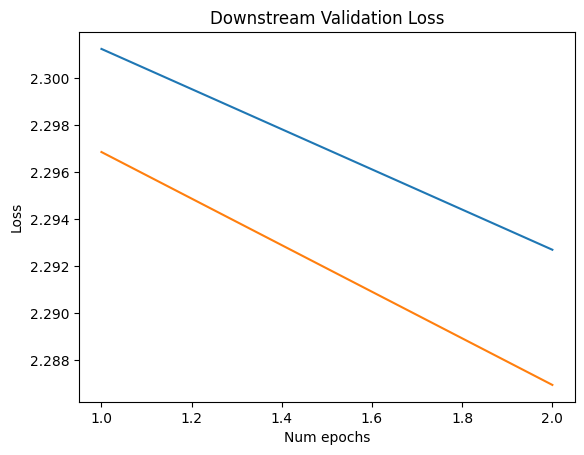

In [20]:
x = np.linspace(1, len(training_losses), len(training_losses))
plt.plot(x, training_losses, label="Training")
plt.xlabel("Num epochs")
plt.ylabel("Loss")
plt.title("Downstream Training Loss")

plt.plot(x, validation_losses, label="Validation")
plt.xlabel("Num epochs")
plt.ylabel("Loss")
plt.title("Downstream Validation Loss")
plt.legend()

plt.show()

In [21]:
correct = 0
total = 0

with torch.no_grad():
    for (images, labels) in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %
